## Imports

In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision.transforms import ToTensor
from torchvision import transforms
import matplotlib.pyplot as plt


## Data 

In [2]:
!mkdir cifar_data

In [3]:
img_size = 64
dataset = torchvision.datasets.CIFAR10(root ='/content/cifar_data' ,
                                   download = True , 
                                   transform = transforms.Compose([
                                      transforms.Resize(img_size),
                                      transforms.CenterCrop(img_size),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean = (0.5 , 0.5 , 0.5) , std = (0.5 , 0.5 , 0.5))
                                   ]))


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting /content/cifar_data/cifar-10-python.tar.gz to /content/cifar_data


In [4]:
img , label = dataset[1]
img.shape

torch.Size([3, 64, 64])

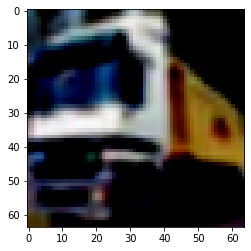

In [5]:
act_img = plt.imshow(img.permute(1,2,0))


In [6]:
# data loader 
data_loader = torch.utils.data.DataLoader(dataset ,
                                          batch_size = 128,
                                          shuffle = True)

![picture](https://drive.google.com/uc?id=1rBKzUCtwQPPLh_F6DVJBDTfkwlUEHugo)

## Generator

![picture](https://drive.google.com/uc?id=1VjNhtF88Lq2MNE4y3vuhMlWEJJm9dKtY)

In [7]:
class Generator(nn.Module):
  def __init__(self , in_channel , out_channel):
    super().__init__()
    self.model2 =  nn.Sequential(
        # Bt_size x C x H xW --> [128 , 100 , 1 , 1]
        nn.ConvTranspose2d(in_channels = in_channel , out_channels = out_channel , kernel_size = 4 , padding =0 , stride = 1 , bias = False),
        nn.BatchNorm2d(num_features = out_channel),
        nn.ReLU(),
        # [128, 1024 ,4,4] --> 128 is the batch size
        nn.ConvTranspose2d(in_channels = out_channel , out_channels = int(out_channel/2) , kernel_size = 4 , padding = 1,stride = 2,bias = False),
        nn.BatchNorm2d(num_features = int(out_channel/2)),
        nn.ReLU(),
        nn.ConvTranspose2d(in_channels = int(out_channel/2) , out_channels = int(out_channel/4) , kernel_size = 4 , padding = 1,stride = 2,bias = False),
        nn.BatchNorm2d(num_features = int(out_channel/4)),
        nn.ReLU(),
        nn.ConvTranspose2d(in_channels = int(out_channel/4), out_channels = int(out_channel/8) , kernel_size = 4 , padding = 1,stride = 2,bias = False),
        nn.BatchNorm2d(num_features =  int(out_channel/8)) ,
        nn.ReLU(),
        nn.ConvTranspose2d(in_channels =  int(out_channel/8)  , out_channels =3, kernel_size = 4 , padding = 1,stride = 2,bias = False),
        nn.Tanh()
    )
    self.weights_init()

  def forward(self , x):
    x2 = self.model2(x)
    return x2

  def weights_init(self):
    for m in self.modules():
      if isinstance(m , nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight , mean = 0 , std = 0.02)
      elif isinstance(m , nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight , 0 , 0.02)
        torch.nn.init.constant_(m.bias , 0)



In [8]:
mdl = Generator(100, 1024)

## hide me

In [9]:
input = torch.rand(size = (100,1,1))

print(input.shape)

torch.Size([100, 1, 1])


In [13]:
print((input.unsqueeze(dim = 0)).shape)


torch.Size([1, 100, 1, 1])


In [14]:
gen_layer = Generator(in_channel = 100 ,out_channel = 1024)
output_from_gen = gen_layer(input.unsqueeze(dim = 0))

In [15]:
output_from_gen.shape

torch.Size([1, 3, 64, 64])

## Discriminator

In [16]:
class Discriminator(nn.Module):
  def __init__(self , nc , ndf):
    super().__init__()
    self.model1 = nn.Sequential(
        # 3x64x64
        nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
        nn.LeakyReLU(0.2, inplace=True),
        # state size. (ndf) x 32 x 32
        nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
        nn.BatchNorm2d(ndf * 2),
        nn.LeakyReLU(0.2, inplace=True),
        # state size. (ndf*2) x 16 x 16
        nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
        nn.BatchNorm2d(ndf * 4),
        nn.LeakyReLU(0.2, inplace=True),
        # state size. (ndf*4) x 8 x 8
        nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
        nn.BatchNorm2d(ndf * 8),
        nn.LeakyReLU(0.2, inplace=True),
        # state size. (ndf*8) x 4 x 4
        nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
        nn.Sigmoid()
    )
    self.weights_init()

  def forward(self , img):
    return self.model1(img)

  def weights_init(self):
    for m in self.modules():
      if isinstance(m , nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight , mean = 0 , std = 0.02)
      elif isinstance(m , nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight , 0 , 0.02)
        torch.nn.init.constant_(m.bias , 0)
 

In [17]:
device =torch.device( 'cuda' if torch.cuda.is_available() else 'cpu')

In [18]:
device

device(type='cpu')

In [19]:
# print(output_from_gen)
netD = Discriminator(nc = 3, ndf = 64)
netG = Generator(in_channel = 100 , out_channel = 1024)
criterion = nn.BCELoss()
lr = 0.0002
beta1 = 0.5
n_z = 100
optimizerG = torch.optim.Adam(netG.parameters() , lr  = lr , betas = (beta1 , 0.999))
optimizerD = torch.optim.Adam(netD.parameters() , lr = lr,  betas = (beta1 , 0.999))
fixed_noise = torch.randn(64, n_z, 1, 1)

In [20]:
print(netG)

Generator(
  (model2): Sequential(
    (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): ConvTranspose2d(128, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [21]:
import torchvision.utils as vutils

![picture](https://drive.google.com/uc?id=1aTyETR9yaTPS40Tt5rOgCbIXrMvkCqay)

In [22]:
# training a gan model

D_loss = []
G_loss = []

num_epochs = 10

# data --> (real ,_)
for epoch in range(num_epochs):
  for batch_index,(real,_) in enumerate(data_loader):
    # real = real.view(-1,12288).to(device) ## flatten the image keeping the batch size intact
    print(real.shape)
    batch_size = real.shape[0]

    # train disc --> max(log(D(real) + log(1-D(G(x))))

    noise = torch.randn(batch_size , n_z).to(device)
    noise = noise[:,:,None,None]
    fake = netG(noise)
    disc_real = netD(real).view(-1) # here we flattened the image
    lossD_real = criterion(disc_real , torch.ones_like(disc_real))

    # second term in the loss function of discriminator
    disc_fake = netD(fake).view(-1)
    lossD_fake = criterion(disc_fake , torch.zeros_like(disc_fake))

    # combine both
    lossD =(lossD_real + lossD_fake )/2
    netD.zero_grad()
    lossD.backward(retain_graph = True)
    optimizerD.step()

    # train gen --> min log(1-D(G(x))) ---  max(log(D(G(x))))
    # rather than minimizing log (1-d(g(x))) which results in weak gradients and sometimes leads to no training --> weak training / vanishing grads 

    output = netD(fake).view(-1)
    lossG = criterion(output , torch.ones_like(output))
    netG.zero_grad()
    lossG.backward()
    optimizerG.step()

    print("epoch is " ,epoch , " batch index is " , batch_index, " the loss of gen is " , lossG , " loss of disc is " , lossD)


![picture](https://drive.google.com/uc?id=1T-KzUNxCIhG_TfQ22SnN95G703srSlcW)

![picture](https://drive.google.com/uc?id=1oG90mJmfj06zs4GLzbKMuPRwNGcK1X-T)

![picture](https://drive.google.com/uc?id=1EFezWaavBOAsV7k5eU_u3VNfT5UBFRKN)